Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers, models
import tensorflow as tf
import pickle
import os
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model
import time
from tqdm import tqdm  
from sklearn.model_selection import StratifiedShuffleSplit
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        os.environ['CUDA_VISIBLE_DEVICES'] = ''

2 Physical GPUs, 2 Logical GPUs


In [2]:
def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        X_ela, X_srm, Y, log = pickle.load(f)
    return np.array(X_ela), np.array(X_srm), np.array(Y), log

In [3]:
X_ela, X_srm, Y, log = load_preprocessed_data('CASIAV2DATA.pkl') #CASIA V2 DATASET LOADED YOU CAN LOAD THE DATASET YOU WANT TO USE

X_ela = X_ela.reshape(-1, 128, 128, 3)
X_srm = X_srm.reshape(-1, 128, 128, 3)

# One-hot encode the labels
Y = to_categorical(Y, 2)

# Stratified split to ensure same class ratio in train and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=5)

for train_index, val_index in sss.split(X_ela, np.argmax(Y, axis=1)):
    X_ela_train, X_ela_val = X_ela[train_index], X_ela[val_index]
    X_srm_train, X_srm_val = X_srm[train_index], X_srm[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

# Print the number of samples
print(f'Training samples: {len(X_ela_train)}, Validation samples: {len(X_ela_val)}')

# Checking the distribution of classes in the training and validation sets
print('Class distribution in training set:', np.bincount(np.argmax(Y_train, axis=1)))
print('Class distribution in validation set:', np.bincount(np.argmax(Y_val, axis=1)))

Training samples: 8476, Validation samples: 942
Class distribution in training set: [1858 6618]
Class distribution in validation set: [206 736]


In [4]:
def build_model():
    # ELA Branch
    input_ela = layers.Input(shape=(128,128,3), name='ELA_Input')
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_ela)
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_ela)
    x_ela = layers.MaxPooling2D((2, 2))(x_ela)

    # SRM Branch
    input_srm = layers.Input(shape=(128,128,3), name='SRM_Input')
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_srm)
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
    x_srm = layers.MaxPooling2D((2, 2))(x_srm)

    # Concatenate the outputs of both branches
    combined = layers.Concatenate()([x_ela, x_srm])
    combined = layers.Dropout(0.25)(combined)  
    combined = layers.Flatten()(combined)

    # Fully connected layer
    fc = layers.Dense(256, activation='relu')(combined)
    fc = layers.Dropout(0.5)(fc) 

    output = layers.Dense(2, activation='softmax')(fc)

    # Create the model
    model = models.Model(inputs=[input_ela, input_srm], outputs=output)
    return model

model = build_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ELA_Input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 SRM_Input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['ELA_Input[0][0]']              
                                )                                                             

In [5]:
epochs = 200
batch_size = 16

optimizer = optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    decay=0.0001
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 7,
                              verbose = 1,
                              mode = 'auto')


In [6]:
no_au = 7354
no_tp = 2064
total_images = no_au + no_tp

weight_for_au = (1 / no_au) * (total_images / 2.0)
weight_for_tp= (1 / no_tp) * (total_images / 2.0)
class_weights = {0: weight_for_tp, 1: weight_for_au}

In [7]:
checkpoint_filepath = 'CasiaModel.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,   
    monitor='val_accuracy',         
    save_best_only=True,            # Save only the best weights
    mode='max',                     
    verbose=1                      
)

In [8]:
hist = model.fit([X_ela_train, X_srm_train],
                    Y_train,
                    batch_size=batch_size,
                    class_weight=class_weights,
                    epochs=epochs,
                    validation_data=([X_ela_val, X_srm_val], Y_val),
                    callbacks=[early_stopping, checkpoint_callback])
    #early stopping implemented to prevent overfitting

Epoch 1/200
530/530 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.8259
Epoch 1: val_accuracy improved from -inf to 0.88110, saving model to finalmodelcasiatest5.h5
530/530 [==============================] - 61s 108ms/step - loss: 0.5214 - accuracy: 0.8259 - val_loss: 0.3013 - val_accuracy: 0.8811
Epoch 2/200
530/530 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8640
Epoch 2: val_accuracy did not improve from 0.88110
530/530 [==============================] - 54s 101ms/step - loss: 0.3252 - accuracy: 0.8640 - val_loss: 0.3203 - val_accuracy: 0.8631
Epoch 3/200
530/530 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.8889
Epoch 3: val_accuracy did not improve from 0.88110
530/530 [==============================] - 55s 103ms/step - loss: 0.2621 - accuracy: 0.8889 - val_loss: 0.3459 - val_accuracy: 0.8567
Epoch 4/200
530/530 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9172
Epoch 4: val_ac

In [9]:
model = load_model('CasiaModel.h5')

In [10]:
history=hist.history
history_dict = hist.history
with open('Casiahistory.pkl', 'wb') as file_pi:
    pickle.dump(history_dict, file_pi)

In [11]:
predictions = model.predict([X_ela_val, X_srm_val])
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(Y_val, axis=1)
def generate_metrics(y_true, y_pred):
    print("Accuracy = " , accuracy_score(y_true, y_pred))
    print("Precision = " ,precision_score(y_true, y_pred))
    print("Recall = " ,recall_score(y_true, y_pred))
    print("F1 Score = " ,f1_score(y_true, y_pred))
    pass# Make predictions

generate_metrics(y_true, y_pred)


30/30 [==============================] - 3s 71ms/step
Accuracy =  0.9617834394904459
Precision =  0.9691689008042895
Recall =  0.9823369565217391
F1 Score =  0.9757085020242915


30/30 [==============================] - 2s 74ms/step


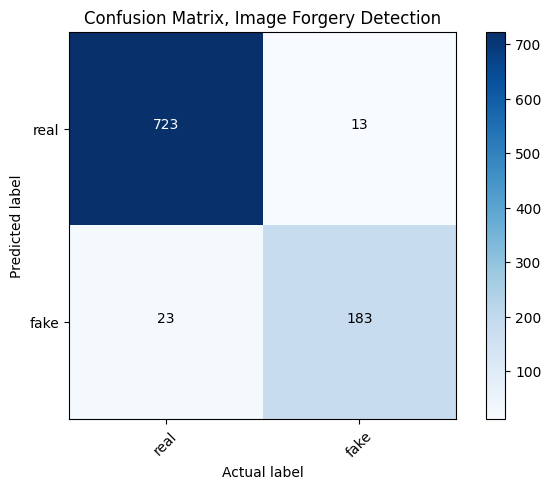

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm_flipped = cm[::-1, ::-1]

    plt.imshow(cm_flipped, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes[::-1], rotation=45)
    plt.yticks(tick_marks, classes[::-1])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm_flipped.shape[0]), range(cm_flipped.shape[1])):
        plt.text(j, i, cm_flipped[i, j],
                 horizontalalignment="center",
                 color="white" if cm_flipped[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('Actual label')

Y_pred = model.predict([X_ela_val, X_srm_val])
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
class_names = ['fake','real']  
plot_confusion_matrix(confusion_mtx, classes=class_names, title='Confusion Matrix, Image Forgery Detection')


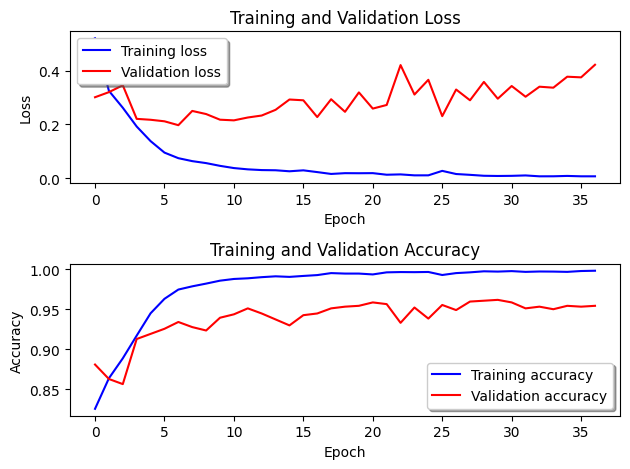

In [13]:
fig, ax = plt.subplots(2, 1)
#code for visulating training and validation loss and accuracy history
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="Validation loss")
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')  
ax[0].set_ylabel('Loss')  
ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')  
ax[1].set_ylabel('Accuracy')  
ax[1].legend(loc='best', shadow=True)
plt.tight_layout()  
plt.show()
